In [63]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from random import randint
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm
from torchsummary import summary


In [39]:
device="mps" if torch.backends.mps.is_available() else "cpu"
print(torch.backends.mps.is_built())
torch.manual_seed(1234)
if device == 'mps':
    torch.cuda.manual_seed_all(1234)

True


### Data Prep

In [40]:
# Load training and validation data from directory
train = pd.read_csv('data/train.csv')
valid = pd.read_csv('data/Dig-MNIST.csv')

In [41]:
# Take a look at first few rows of the training data
# column 0 is the label
# column 1-784 are the flattened picture
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# Take a look at first few rows of the validation data
valid.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# define and normalize training features
train_img = train.iloc[:,1:].astype('float').values/255.0
# define training labels
train_label = train.iloc[:,0].values
# define and normalize validation features
valid_img = valid.iloc[:,1:].astype('float').values/255.0
# define validation labels
valid_label = valid.iloc[:,0].values

#### Plot some training data

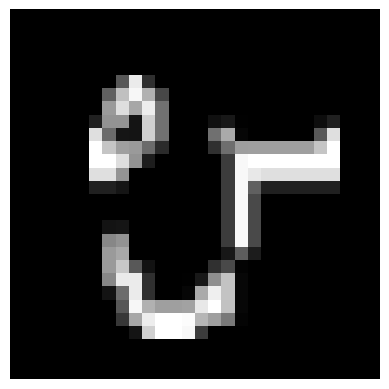

In [44]:
image_array = train_img[randint(0, 60000)].reshape(28, 28)

plt.imshow(image_array, cmap='gray')  # Use grayscale colormap
plt.axis('off')  # Turn off axis
plt.show()

In [45]:
# Create custome dataset
class dataset(Dataset):
    def __init__(self, images, labels):
        self.img = images
        self.labels = labels
        

    def __len__(self):
        return len(self.img)

    def __getitem__(self,idx):
        image = self.img[idx].reshape(-1,28,28)
        # reshape the images into 28 x 28 matrix
        label = self.labels[idx]

        return torch.tensor(image.astype('float32')).to(device), torch.tensor(label.astype('float32')).to(device)
        # creates PyTorch tensors from image and its corresponding label,
        # ensuring they are of data type float32, and then moves these tensors to device (either GPU or CPU).

# use this dataset class we just created to create your training and validation datasets:      
trainset = dataset(train_img,train_label)
validset = dataset(valid_img,valid_label)

#### Load data

In [46]:
batch_size = 128

train_loader = DataLoader(trainset,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(validset,batch_size=batch_size,shuffle=True)

### Define the model

In [47]:
#  I chose to train my data using a CNN architecture
    # 6 convolution layers followed by batch normalization to normalize the activations
    # ReLU activation is applied after bacth normalization
    # Dropout is used in layers 
    # max-pooling layers are applied for dimension reduction

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # conv1
        self.bn1 = nn.BatchNorm2d(16, momentum=0.1, eps=1e-5)  # batch1
        self.relu1 = nn.ReLU(inplace=True)  # relu1
        self.dropout1 = nn.Dropout2d(p=0.1)  # dropout1

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # conv2
        self.bn2 = nn.BatchNorm2d(32, momentum=0.15, eps=1e-5)  # batch2
        self.relu2 = nn.ReLU(inplace=True)  # relu2
        self.dropout2 = nn.Dropout2d(p=0.15)  # dropout2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # max2

        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)  # conv3
        self.bn3 = nn.BatchNorm2d(64, momentum=0.17, eps=1e-5)  # batch3
        self.relu3 = nn.ReLU(inplace=True)  # relu3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # max3

        self.conv4 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2)  # conv4
        self.bn4 = nn.BatchNorm2d(64, momentum=0.15, eps=1e-5)  # batch4
        self.relu4 = nn.ReLU(inplace=True)  # relu4
        self.dropout4 = nn.Dropout2d(p=0.17)  # dropout4

        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)  # conv5
        self.bn5 = nn.BatchNorm2d(32, momentum=0.15, eps=1e-5)  # batch5
        self.relu5 = nn.ReLU(inplace=True)  # relu5
        self.dropout5 = nn.Dropout2d(p=0.2)  # dropout5

        self.conv6 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)  # conv6
        self.bn6 = nn.BatchNorm2d(16, momentum=0.15, eps=1e-5)  # batch6
        self.relu6 = nn.ReLU(inplace=True)  # relu6
        self.dropout6 = nn.Dropout2d(p=0.05)  # dropout6
        #Fully connected layers process the features extracted by the convolutional layers and make predictions.
          # ReLU activation is applied after each fully connected layer.
          # Dropout is used for regularization.
        self.fc1 = nn.Linear(16 * 7 * 7, 50)  # Dense1
        self.relu7 = nn.ReLU(inplace=True)  # relu7
        self.dropout7 = nn.Dropout(p=0.05)  # dropout7

        self.fc2 = nn.Linear(50, 25)  # Dense2
        self.relu8 = nn.ReLU(inplace=True)  # relu8
        self.dropout8 = nn.Dropout(p=0.03)  # dropout8

        self.fc3 = nn.Linear(25, 10)  # Dense3
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # defines the forward pass of the network and specifies how data flows through the network layers.
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.dropout4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.dropout5(x)

        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.dropout6(x)

        x = x.view(-1, 16 * 7 * 7)

        x = self.fc1(x)
        x = self.relu7(x)
        x = self.dropout7(x)

        x = self.fc2(x)
        x = self.relu8(x)
        x = self.dropout8(x)

        x = self.fc3(x)
        x = self.softmax(x)

        return x

# Initialize the model
model = CNN().to(device)
summary(model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            160
├─BatchNorm2d: 1-2                       32
├─ReLU: 1-3                              --
├─Dropout2d: 1-4                         --
├─Conv2d: 1-5                            4,640
├─BatchNorm2d: 1-6                       64
├─ReLU: 1-7                              --
├─Dropout2d: 1-8                         --
├─MaxPool2d: 1-9                         --
├─Conv2d: 1-10                           51,264
├─BatchNorm2d: 1-11                      128
├─ReLU: 1-12                             --
├─MaxPool2d: 1-13                        --
├─Conv2d: 1-14                           102,464
├─BatchNorm2d: 1-15                      128
├─ReLU: 1-16                             --
├─Dropout2d: 1-17                        --
├─Conv2d: 1-18                           18,464
├─BatchNorm2d: 1-19                      64
├─ReLU: 1-20                             --
├─Dropout2d: 1-21                        --
├─Conv2d

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            160
├─BatchNorm2d: 1-2                       32
├─ReLU: 1-3                              --
├─Dropout2d: 1-4                         --
├─Conv2d: 1-5                            4,640
├─BatchNorm2d: 1-6                       64
├─ReLU: 1-7                              --
├─Dropout2d: 1-8                         --
├─MaxPool2d: 1-9                         --
├─Conv2d: 1-10                           51,264
├─BatchNorm2d: 1-11                      128
├─ReLU: 1-12                             --
├─MaxPool2d: 1-13                        --
├─Conv2d: 1-14                           102,464
├─BatchNorm2d: 1-15                      128
├─ReLU: 1-16                             --
├─Dropout2d: 1-17                        --
├─Conv2d: 1-18                           18,464
├─BatchNorm2d: 1-19                      64
├─ReLU: 1-20                             --
├─Dropout2d: 1-21                        --
├─Conv2d

In [48]:
epochs = 10
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

#### Early Stopping

In [49]:
'''
Source : https://github.com/Bjarten/early-stopping-pytorch
'''
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

#### Train the model

In [50]:
# Initialize the EarlyStopping object
early_stopping = EarlyStopping(patience=3, verbose=True)

# Define the number of epochs
epochs = 100

# Loop over epochs
for epoch in range(epochs):
    model.train()  # Set the model to train mode
    train_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch'):
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        # Compute training statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Compute average training loss and accuracy
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    
    # Evaluate the model on the validation data
    model.eval()  # Set the model to evaluation mode
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc='Validating', unit='batch'):
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss

            # Compute validation statistics
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # Compute average validation loss and accuracy
    valid_loss /= len(valid_loader)
    valid_accuracy = 100. * correct / total
    print(f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%')

    # Check if validation loss has improved, if not, apply early stopping
    early_stopping(valid_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break  # Stop training if early stopping criteria are met


Epoch 1/100: 100%|██████████| 469/469 [00:35<00:00, 13.23batch/s]


Train Loss: 1.5486, Train Accuracy: 92.34%


Validating: 100%|██████████| 80/80 [00:04<00:00, 17.54batch/s]


Validation Loss: 1.7321, Validation Accuracy: 73.20%
Validation loss decreased (inf --> 1.732124).  Saving model ...


Epoch 2/100: 100%|██████████| 469/469 [00:36<00:00, 12.80batch/s]


Train Loss: 1.4758, Train Accuracy: 98.66%


Validating: 100%|██████████| 80/80 [00:04<00:00, 17.60batch/s]


Validation Loss: 1.6868, Validation Accuracy: 77.59%
Validation loss decreased (1.732124 --> 1.686771).  Saving model ...


Epoch 3/100: 100%|██████████| 469/469 [00:34<00:00, 13.62batch/s]


Train Loss: 1.4723, Train Accuracy: 98.94%


Validating: 100%|██████████| 80/80 [00:04<00:00, 17.33batch/s]


Validation Loss: 1.7241, Validation Accuracy: 73.61%
EarlyStopping counter: 1 out of 3


Epoch 4/100: 100%|██████████| 469/469 [00:34<00:00, 13.77batch/s]


Train Loss: 1.4706, Train Accuracy: 99.09%


Validating: 100%|██████████| 80/80 [00:04<00:00, 17.30batch/s]


Validation Loss: 1.6683, Validation Accuracy: 79.21%
Validation loss decreased (1.686771 --> 1.668267).  Saving model ...


Epoch 5/100: 100%|██████████| 469/469 [00:34<00:00, 13.56batch/s]


Train Loss: 1.4699, Train Accuracy: 99.15%


Validating: 100%|██████████| 80/80 [00:04<00:00, 17.44batch/s]


Validation Loss: 1.6667, Validation Accuracy: 79.38%
Validation loss decreased (1.668267 --> 1.666726).  Saving model ...


Epoch 6/100: 100%|██████████| 469/469 [00:34<00:00, 13.64batch/s]


Train Loss: 1.4692, Train Accuracy: 99.22%


Validating: 100%|██████████| 80/80 [00:04<00:00, 16.67batch/s]


Validation Loss: 1.6755, Validation Accuracy: 78.47%
EarlyStopping counter: 1 out of 3


Epoch 7/100: 100%|██████████| 469/469 [00:34<00:00, 13.49batch/s]


Train Loss: 1.4700, Train Accuracy: 99.14%


Validating: 100%|██████████| 80/80 [00:04<00:00, 17.70batch/s]


Validation Loss: 1.6621, Validation Accuracy: 79.90%
Validation loss decreased (1.666726 --> 1.662126).  Saving model ...


Epoch 8/100: 100%|██████████| 469/469 [00:34<00:00, 13.77batch/s]


Train Loss: 1.4681, Train Accuracy: 99.31%


Validating: 100%|██████████| 80/80 [00:04<00:00, 17.41batch/s]


Validation Loss: 1.6422, Validation Accuracy: 81.90%
Validation loss decreased (1.662126 --> 1.642187).  Saving model ...


Epoch 9/100: 100%|██████████| 469/469 [00:34<00:00, 13.79batch/s]


Train Loss: 1.4676, Train Accuracy: 99.37%


Validating: 100%|██████████| 80/80 [00:04<00:00, 17.59batch/s]


Validation Loss: 1.7122, Validation Accuracy: 74.91%
EarlyStopping counter: 1 out of 3


Epoch 10/100: 100%|██████████| 469/469 [00:34<00:00, 13.51batch/s]


Train Loss: 1.4680, Train Accuracy: 99.32%


Validating: 100%|██████████| 80/80 [00:04<00:00, 17.62batch/s]


Validation Loss: 1.6933, Validation Accuracy: 76.73%
EarlyStopping counter: 2 out of 3


Epoch 11/100: 100%|██████████| 469/469 [00:34<00:00, 13.61batch/s]


Train Loss: 1.4679, Train Accuracy: 99.34%


Validating: 100%|██████████| 80/80 [00:04<00:00, 17.29batch/s]

Validation Loss: 1.7241, Validation Accuracy: 73.52%
EarlyStopping counter: 3 out of 3
Early stopping


### Use the CNN model to predict the test dataset
Before earlystopping, the saved model's accuracy on validation dataset is 81.90.

In [51]:
# Create a costume dataset for testing data
class testDataset(Dataset):
    def __init__(self, images):
        self.img = images

    def __len__(self):
        return len(self.img)

    def __getitem__(self,idx):
        image = self.img[idx].reshape(-1,28,28)

        return torch.tensor(image.astype('float32')).to(device)

In [52]:
# Load test data
test = pd.read_csv('data/test.csv')
test_img = test.iloc[:,1:].astype('float').values/255.0

testset = testDataset(test_img)
test_loader = DataLoader(testset,batch_size=batch_size,shuffle=False)

In [53]:
# Create an empty list to store predictions
test_predictions = []

# Set the model to evaluation mode
model.eval()

# Iterate over the test data
with torch.no_grad():
    for images in tqdm(test_loader, desc='Predicting', unit='batch'):
        # Forward pass
        outputs = model(images)
        # Get the predicted class (index with maximum probability)
        _, predicted = torch.max(outputs, 1)
        # Convert tensor to list and append to test_predictions
        test_predictions.extend(predicted.cpu().tolist())

# Print the first few predictions as an example
print("First few predictions:", test_predictions[:10])


Predicting: 100%|██████████| 40/40 [00:01<00:00, 21.45batch/s]

First few predictions: [3, 0, 2, 6, 7, 7, 1, 9, 3, 4]


In [54]:
submission = pd.read_csv('data/sample_submission.csv')
submission['label'] = test_predictions
submission.to_csv('submission.csv', index=False)
submission.head()

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7


In [60]:
from torchviz import make_dot
input_size = (1, 1, 28, 28)
sample_input = torch.randn(input_size).to(device)

output = model(sample_input)
graph = make_dot(output, params=dict(model.named_parameters()))

graph.render(filename='cnn_graph', format='png', cleanup=True)

graph.view()

'cnn_graph.pdf'

### Model Visualization

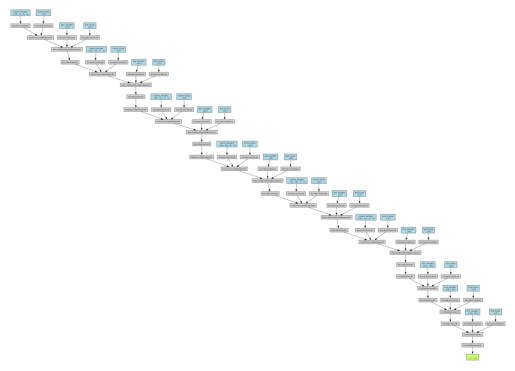

In [67]:
cnn_graph = Image.open('/Users/carriexia/Desktop/spring_2023/computer_vision/assignment_1/cnn_graph.png')
plt.imshow(cnn_graph)
plt.axis('off')  # Turn off axis
plt.show()